# 19 · Detección, descriptores y **matching** entre vistas (ORB/SIFT)

En este cuaderno:
1. Detectamos **puntos clave** y calculamos **descriptores** (ORB y SIFT si está disponible).
2. Generamos una **segunda vista** de la imagen (rotación + ligera escala / perspectiva).
3. Emparejamos puntos entre ambas vistas y visualizamos **coincidencias**.
4. Estimamos una **homografía con RANSAC** para separar **inliers/outliers** y mostrar el **encuadre** proyectado.



## 1) Librerías y funciones auxiliares

In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt

def show(img, title=None, cmap=None, size=(5,5)):
    plt.figure(figsize=size)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def to_rgb(bgr):
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def rotate_scale(img, angle_deg=20, scale=1.05, border=cv2.BORDER_REFLECT101):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, scale)
    out = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=border)
    return out

def warp_perspective_small(img, dx=0.06, dy=0.04):
    # Pequeña homografía para simular cambio de punto de vista
    h, w = img.shape[:2]
    src = np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    dst = np.float32([[w*dx, h*dy],[w-1-w*dx, h*0.02],[w-1-w*0.02,h-1-h*dy],[w*0.02,h-1-h*0.02]])
    H = cv2.getPerspectiveTransform(src, dst)
    out = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)
    return out

def draw_matches(img1, kps1, img2, kps2, matches, max_draw=60, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS):
    # Ordena por distancia ascendente y dibuja las primeras
    matches = sorted(matches, key=lambda m: m.distance)[:max_draw]
    vis = cv2.drawMatches(to_rgb(img1), kps1, to_rgb(img2), kps2, matches, None, flags=flags)
    show(vis, f"Mejores {len(matches)} coincidencias")
    return vis

## 2) Cargar Imagen y generar segunda vista

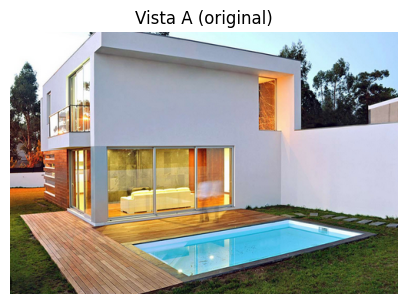

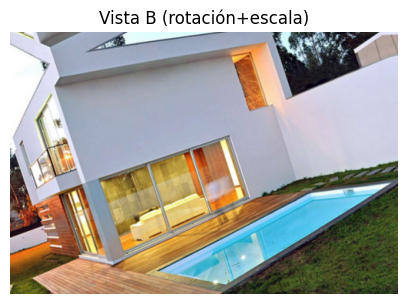

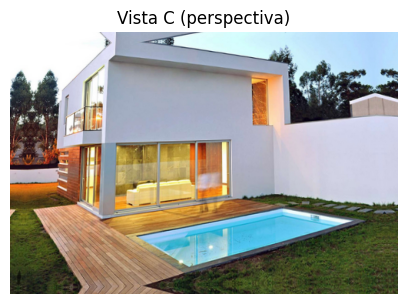

In [2]:
IMG_PATH = r"C:\Users\20808\Documents\Repositorios\Vision_en_Robotica\imagenes\casa.png"
img = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Genera dos variantes: (a) rotación+escala y (b) pequeña perspectiva
img_b = rotate_scale(img, angle_deg=18, scale=1.08)
img_c = warp_perspective_small(img, dx=0.07, dy=0.05)

show(to_rgb(img), "Vista A (original)")
show(to_rgb(img_b), "Vista B (rotación+escala)")
show(to_rgb(img_c), "Vista C (perspectiva)")

## 3) ORB: detección, descriptores y matching

ORB: A=789 puntos, B=776 puntos, descA=(789, 32), descB=(776, 32)


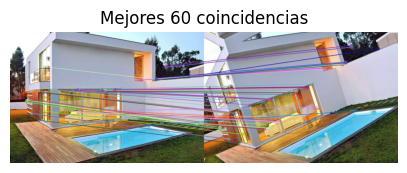

In [3]:
# Detectar y describir con ORB
orb = cv2.ORB_create(nfeatures=800, scaleFactor=1.2, nlevels=8)
kpsA_orb, desA_orb = orb.detectAndCompute(gray, None)
kpsB_orb, desB_orb = orb.detectAndCompute(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), None)

print(f"ORB: A={len(kpsA_orb)} puntos, B={len(kpsB_orb)} puntos, descA={None if desA_orb is None else desA_orb.shape}, descB={None if desB_orb is None else desB_orb.shape}")

# Emparejar con BFMatcher Hamming (porque ORB -> binario)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches_orb = []
if desA_orb is not None and desB_orb is not None:
    matches_orb = bf.match(desA_orb, desB_orb)

_ = draw_matches(img, kpsA_orb, img_b, kpsB_orb, matches_orb, max_draw=60)

### 3.1 ORB + RANSAC (homografía)

ORB: inliers=218, outliers=87


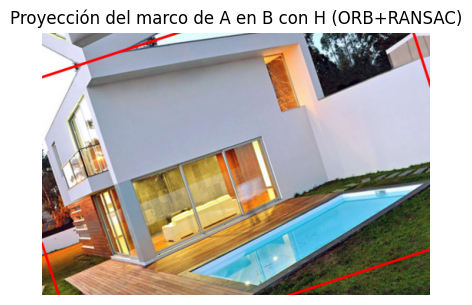

In [4]:
def ransac_homography(kps1, kps2, matches, ransacReprojThreshold=3.0):
    if not matches:
        return None, [], []
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacReprojThreshold)
    inliers = [matches[i] for i in range(len(matches)) if mask[i,0]==1] if mask is not None else []
    outliers = [matches[i] for i in range(len(matches)) if mask[i,0]==0] if mask is not None else []
    return H, inliers, outliers

H_orb, in_orb, out_orb = ransac_homography(kpsA_orb, kpsB_orb, matches_orb, 3.0)
print(f"ORB: inliers={len(in_orb)}, outliers={len(out_orb)}")

if H_orb is not None:
    h, w = img.shape[:2]
    box = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    proj = cv2.perspectiveTransform(box, H_orb)
    vis = to_rgb(img_b).copy()
    cv2.polylines(vis, [np.int32(proj)], True, (255,0,0), 2, cv2.LINE_AA)
    show(vis, "Proyección del marco de A en B con H (ORB+RANSAC)")

## 4) SIFT (si está disponible): detección, descriptores y matching

SIFT: A=748 puntos, B=800 puntos, descA=(748, 128), descB=(800, 128)


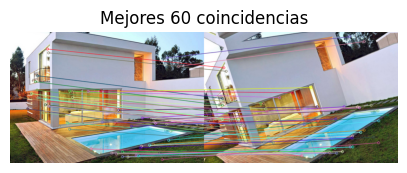

SIFT: inliers=338, outliers=7


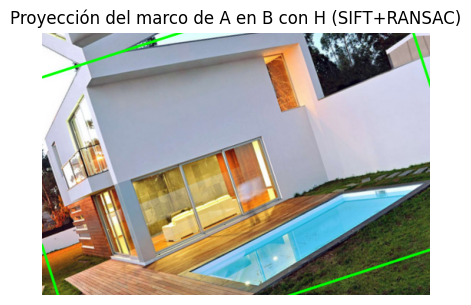

In [5]:
have_sift = hasattr(cv2, 'SIFT_create')
if have_sift:
    sift = cv2.SIFT_create(nfeatures=800)
    kpsA_sift, desA_sift = sift.detectAndCompute(gray, None)
    kpsB_sift, desB_sift = sift.detectAndCompute(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), None)
    print(f"SIFT: A={len(kpsA_sift)} puntos, B={len(kpsB_sift)} puntos, descA={None if desA_sift is None else desA_sift.shape}, descB={None if desB_sift is None else desB_sift.shape}")

    # FLANN para descriptores float (SIFT)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=64)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches_sift = []
    if desA_sift is not None and desB_sift is not None:
        # KNN + ratio test de Lowe
        knn = flann.knnMatch(desA_sift, desB_sift, k=2)
        for m,n in knn:
            if m.distance < 0.75 * n.distance:
                matches_sift.append(m)

    _ = draw_matches(img, kpsA_sift, img_b, kpsB_sift, matches_sift, max_draw=60)

    # RANSAC
    H_sift, in_sift, out_sift = None, [], []
    if matches_sift:
        H_sift, in_sift, out_sift = (lambda HIO: HIO)(ransac_homography(kpsA_sift, kpsB_sift, matches_sift, 3.0))
        print(f"SIFT: inliers={len(in_sift)}, outliers={len(out_sift)}")
        if H_sift is not None:
            h, w = img.shape[:2]
            box = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
            proj = cv2.perspectiveTransform(box, H_sift)
            vis = to_rgb(img_b).copy()
            cv2.polylines(vis, [np.int32(proj)], True, (0,255,0), 2, cv2.LINE_AA)
            show(vis, "Proyección del marco de A en B con H (SIFT+RANSAC)")
else:
    print("SIFT no disponible en tu instalación de OpenCV (cv2.SIFT_create).")

## 5) Matching hacia vista con **perspectiva**

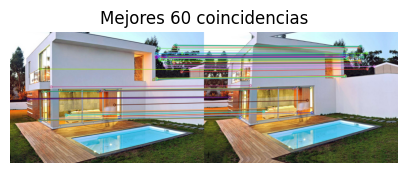

ORB (A→C): inliers=362, outliers=37


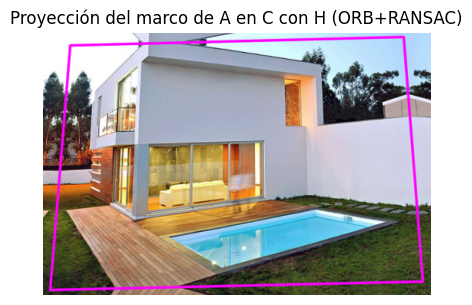

In [6]:
# Puedes alternar entre B (rot+escala) y C (perspectiva). Aquí probamos ORB contra C.
kpsC_orb, desC_orb = orb.detectAndCompute(cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY), None)
matches_orb_C = []
if desA_orb is not None and desC_orb is not None:
    matches_orb_C = bf.match(desA_orb, desC_orb)

_ = draw_matches(img, kpsA_orb, img_c, kpsC_orb, matches_orb_C, max_draw=60)
H_orb_C, in_orb_C, out_orb_C = ransac_homography(kpsA_orb, kpsC_orb, matches_orb_C, 3.0)
print(f"ORB (A→C): inliers={len(in_orb_C)}, outliers={len(out_orb_C)}")
if H_orb_C is not None:
    h, w = img.shape[:2]
    box = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
    proj = cv2.perspectiveTransform(box, H_orb_C)
    vis = to_rgb(img_c).copy()
    cv2.polylines(vis, [np.int32(proj)], True, (255,0,255), 2, cv2.LINE_AA)
    show(vis, "Proyección del marco de A en C con H (ORB+RANSAC)")

## 6) Resumen

- **Puntos clave (keypoints)**: ubicaciones (x, y) robustas de la imagen. ORB incluye **orientación y escala discretizada**.
- **Descriptores**: vectores que describen el vecindario. ORB usa BRIEF binario → rápido; SIFT usa flotantes → robusto.
- **Matching**: se buscan pares con **menor distancia de descriptor** (Hamming para ORB, L2/FLANN para SIFT).
- **RANSAC + Homografía**: filtra outliers y estima una transformación 3×3 que explica la correspondencia entre vistas (si hay modelo plano o cámara fija).

**Reglas prácticas**:
- Para **tiempo real** (SLAM ligero), **ORB** es una gran opción.
- Para matching robusto entre vistas muy distintas, **SIFT** suele dar más inliers (si está disponible).
- Si el número de outliers es alto, sube la exigencia (más puntos, `ratio test` más estricto, o `crossCheck=True`), o aplica una **NMS** mejor en los detectores.
